In [1]:
import pandas as pd

# Modelo linear

## Lendo o dataset

In [2]:
from sklearn.datasets import load_diabetes

data = load_diabetes(as_frame=True, scaled=False)

In [3]:
print(data.DESCR)

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

:Number of Instances: 442

:Number of Attributes: First 10 columns are numeric predictive values

:Target: Column 11 is a quantitative measure of disease progression one year after baseline

:Attribute Information:
    - age     age in years
    - sex
    - bmi     body mass index
    - bp      average blood pressure
    - s1      tc, total serum cholesterol
    - s2      ldl, low-density lipoproteins
    - s3      hdl, high-density lipoproteins
    - s4      tch, total cholesterol / HDL
    - s5      ltg, possibly log of serum triglycerides level
    - s6      glu, blood sugar level

Note: Each of these 10 feature variables have bee

In [4]:
data.frame.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,59.0,2.0,32.1,101.0,157.0,93.2,38.0,4.0,4.8598,87.0,151.0
1,48.0,1.0,21.6,87.0,183.0,103.2,70.0,3.0,3.8918,69.0,75.0
2,72.0,2.0,30.5,93.0,156.0,93.6,41.0,4.0,4.6728,85.0,141.0
3,24.0,1.0,25.3,84.0,198.0,131.4,40.0,5.0,4.8903,89.0,206.0
4,50.0,1.0,23.0,101.0,192.0,125.4,52.0,4.0,4.2905,80.0,135.0


In [5]:
from sklearn.model_selection import train_test_split

train_dataset, test_dataset = train_test_split(
    data.frame,
    test_size=0.2,
    random_state=42,
)

In [6]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 353 entries, 17 to 102
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     353 non-null    float64
 1   sex     353 non-null    float64
 2   bmi     353 non-null    float64
 3   bp      353 non-null    float64
 4   s1      353 non-null    float64
 5   s2      353 non-null    float64
 6   s3      353 non-null    float64
 7   s4      353 non-null    float64
 8   s5      353 non-null    float64
 9   s6      353 non-null    float64
 10  target  353 non-null    float64
dtypes: float64(11)
memory usage: 33.1 KB


In [7]:
train_dataset.describe().round(2).transpose()

,count,mean,std,min,25%,50%,75%,max
age,353.0,48.92,12.76,19.00,40.00,51.00,59.00,79.00
sex,353.0,1.47,0.50,1.00,1.00,1.00,2.00,2.00
bmi,353.0,26.54,4.39,18.10,23.40,25.90,29.40,41.30
bp,353.0,94.99,14.08,62.00,84.00,93.00,105.00,133.00
s1,353.0,188.74,34.73,110.00,163.00,186.00,208.00,301.00
s2,353.0,114.92,30.42,41.60,94.60,112.80,132.80,242.40
s3,353.0,49.52,12.78,22.00,41.00,48.00,57.00,99.00
s4,353.0,4.08,1.30,2.00,3.00,4.00,5.00,9.09
s5,353.0,4.65,0.52,3.26,4.28,4.63,5.01,6.11
s6,353.0,91.72,11.68,58.00,84.00,92.00,99.00,124.00


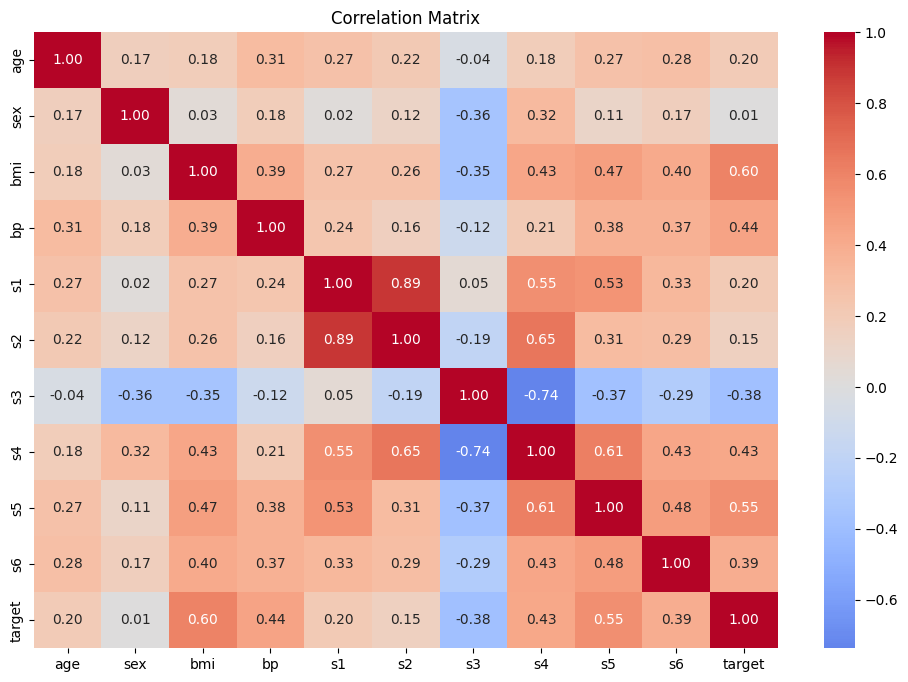

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12, 8))
sns.heatmap(
    train_dataset.corr(),
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    center=0,
)
plt.title('Correlation Matrix')
plt.show()

In [9]:
X_train = train_dataset.drop(columns='target')
y_train = train_dataset['target'].values

X_test = test_dataset.drop(columns='target')
y_test = test_dataset['target'].values


## Um modelo linear simples e alguns mais "chiques"

### Uma mega-função para rodar o experimento completo para cada modelo

In [10]:
from sklearn.metrics import root_mean_squared_error

import matplotlib.pyplot as plt


def run_experiment(
    model,
    get_model_params_fn,
    X_train,
    y_train,
    X_test,
    y_test,
):

    def compute_predictions(fitted_model, X_train, X_test):
        y_train_pred = fitted_model.predict(X_train)
        y_test_pred = fitted_model.predict(X_test)

        return y_train_pred, y_test_pred

    def compute_rmse(fitted_model, y, y_pred):
        return root_mean_squared_error(y, y_pred)

    def print_rmse(label, rmse):
        print(f'{label} RMSE: {rmse:.2f}')

    def print_linear_model_formula(intercept, coefs):
        print('y_pred = ')
        print(f'      ({intercept: 8.2f})')
        for i, coef in enumerate(coefs):
            print(f'    + ({coef: 8.2f}) * X_{i+1}')
        print()

        fitted_model = model.fit(X_train, y_train)
        y_train_pred, y_test_pred = compute_predictions(
            fitted_model,
            X_train,
            X_test,
        )

    def plot_residuals(y_train, y_train_pred, y_test, y_test_pred):

        def plot_scatter_and_residuals(
            y,
            y_pred,
            color,
            label,
        ):
            plt.scatter(
                y,
                y_pred,
                color=color,
                marker='o',
                label=label,
                alpha=0.5,
            )
            for y_value, y_pred_value in zip(y, y_pred):
                plt.plot(
                    [y_value, y_value],
                    [y_value, y_pred_value],
                    color=color,
                    linestyle='--',
                    lw=0.5,
                    alpha=0.5,
                )

        plt.figure(figsize=(12, 6))

        plot_scatter_and_residuals(y_train, y_train_pred, 'blue', 'Train')
        plot_scatter_and_residuals(y_test, y_test_pred, 'orange', 'Test')

        min_y = min(y_train.min(), y_test.min())
        max_y = max(y_train.max(), y_test.max())
        plt.plot(
            [min_y, max_y],
            [min_y, max_y],
            'k--',
            lw=2,
            label='Perfect prediction',
        )
        plt.xlim(min_y, max_y)
        plt.ylim(min_y, max_y)
        plt.gca().set_aspect('equal', adjustable='box')
        plt.grid()
        plt.xlabel('True values')
        plt.ylabel('Predicted values')
        plt.title('True vs Predicted values')
        plt.legend()
        plt.tight_layout()
        plt.show()

    fitted_model = model.fit(X_train, y_train)

    y_train_pred, y_test_pred = compute_predictions(
        fitted_model,
        X_train,
        X_test,
    )

    train_rmse = compute_rmse(fitted_model, y_train, y_train_pred)
    test_rmse = compute_rmse(fitted_model, y_test, y_test_pred)

    print_rmse('Train', train_rmse)
    print_rmse('Test', test_rmse)

    intercept, coefs = get_model_params_fn(fitted_model)
    print_linear_model_formula(intercept, coefs)

    plot_residuals(
        y_train,
        y_train_pred,
        y_test,
        y_test_pred,
    )


### Definindo os modelos

#### O modelo mais simples possível

In [11]:
from sklearn.linear_model import LinearRegression


def create_simple_linear_model():
    return LinearRegression()


def get_simple_model_params(model):
    return model.intercept_, model.coef_

#### Um modelo simples mas precedido de uma pipeline de pré-processamento

- O código da pipeline de pré-processamento

In [12]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler


def create_pipeline_model_with_preprocessing(model):

    def create_basic_preprocessing_pipeline():
        # Create the various stages of the Pipeline. You could do it directly 
        # in the Pipeline constructor, but this is more readable, though a bit
        # more verbose.

        # The imputer will replace missing values with the mean of the column.
        imputer_stage = SimpleImputer(strategy='mean')

        # The polynomial features stage will create polynomial features of 
        # degree 2.
        poly_stage = PolynomialFeatures(degree=2, include_bias=False)

        # The scaler will standardize the features (mean=0, variance=1).
        scaler_stage = StandardScaler()

        # Now join them together in a Pipeline.
        preprocessing_pipe = Pipeline([
            ('imputer', imputer_stage),
            ('poly', poly_stage),
            ('scaler', scaler_stage),
        ])

        return preprocessing_pipe

    # Create the preprocessing pipeline.
    preprocessing_pipe = create_basic_preprocessing_pipeline()

    # Join the preprocessing and model stages in a single pipeline.
    # This is the final pipeline that will be used for training and prediction.
    pipe = Pipeline([
        ('preprocessing', preprocessing_pipe),
        ('model', model),
    ])

    return pipe


def get_pipeline_model_params(model):
    # Get the model stage from the pipeline.
    model_stage = model.named_steps['model']

    # Get the intercept and coefficients from the model.
    intercept = model_stage.intercept_
    coefs = model_stage.coef_

    return intercept, coefs

- O modelo simples com pré-processamento

In [13]:
def create_linear_model_with_preprocessing():
    # Create the regression model.
    model = LinearRegression()

    # Create the pipeline model.
    pipe = create_pipeline_model_with_preprocessing(model)

    return pipe

#### Um modelo de regressão Ridge com pre-processamento

In [14]:
from sklearn.linear_model import Ridge

def create_ridge_model_with_preprocessing():
    # Create the regression model with Ridge regularization.
    model = Ridge(alpha=5.0)

    # Create the pipeline model.
    pipe = create_pipeline_model_with_preprocessing(model)

    return pipe

#### Um modelo de regressão Lasso com pre-processamento

In [15]:
from sklearn.linear_model import Lasso

def create_lasso_model_with_preprocessing():
    # Create the regression model with Ridge regularization.
    model = Lasso(alpha=5.0)

    # Create the pipeline model.
    pipe = create_pipeline_model_with_preprocessing(model)

    return pipe

## Cria os modelos

In [16]:
simple_linear_model = create_simple_linear_model()
simple_linear_model

LinearRegression()

In [17]:
linear_model = create_linear_model_with_preprocessing()
linear_model

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('imputer', SimpleImputer()),
                                 ('poly',
                                  PolynomialFeatures(include_bias=False)),
                                 ('scaler', StandardScaler())])),
                ('model', LinearRegression())])

In [18]:
ridge_model = create_ridge_model_with_preprocessing()
ridge_model

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('imputer', SimpleImputer()),
                                 ('poly',
                                  PolynomialFeatures(include_bias=False)),
                                 ('scaler', StandardScaler())])),
                ('model', Ridge(alpha=5.0))])

In [19]:
lasso_model = create_lasso_model_with_preprocessing()
lasso_model

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('imputer', SimpleImputer()),
                                 ('poly',
                                  PolynomialFeatures(include_bias=False)),
                                 ('scaler', StandardScaler())])),
                ('model', Lasso(alpha=5.0))])

## Escolha de modelo

### Versão simples: train-test-val split

In [20]:
(
    X_train_val,
    X_test_val,
    y_train_val,
    y_test_val,
) = train_test_split(
    X_train,
    y_train,
    test_size=0.2,
    random_state=42,
)

Train RMSE: 53.84
Test RMSE: 53.37
y_pred = 
      ( -356.27)
    + (    0.03) * X_1
    + (  -23.52) * X_2
    + (    5.90) * X_3
    + (    1.12) * X_4
    + (   -1.27) * X_5
    + (    0.74) * X_6
    + (    0.64) * X_7
    + (   10.81) * X_8
    + (   69.70) * X_9
    + (    0.34) * X_10



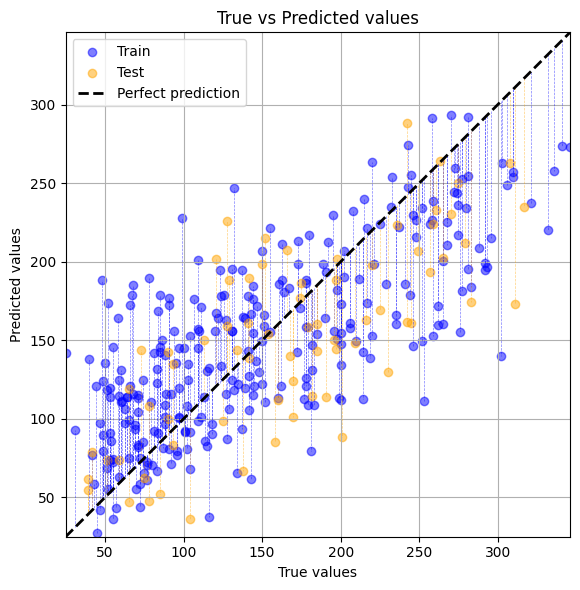

In [21]:
run_experiment(
    simple_linear_model,
    get_simple_model_params,
    X_train_val,
    y_train_val,
    X_test_val,
    y_test_val,
)

Train RMSE: 48.28
Test RMSE: 59.41
y_pred = 
      (  149.78)
    + ( -142.07) * X_1
    + (   15.60) * X_2
    + ( -200.41) * X_3
    + (  211.97) * X_4
    + (  878.86) * X_5
    + ( -776.75) * X_6
    + ( -134.37) * X_7
    + (  192.05) * X_8
    + ( -170.12) * X_9
    + ( -195.98) * X_10
    + (   43.70) * X_11
    + (   23.39) * X_12
    + (   -8.80) * X_13
    + (   15.49) * X_14
    + (  -83.74) * X_15
    + (  -56.73) * X_16
    + (   82.69) * X_17
    + (   97.49) * X_18
    + (   67.80) * X_19
    + (    6.95) * X_20
    + (   15.60) * X_21
    + (   10.27) * X_22
    + (   34.56) * X_23
    + (  182.81) * X_24
    + (  -66.78) * X_25
    + (  -74.76) * X_26
    + ( -118.63) * X_27
    + (  -76.86) * X_28
    + (    8.65) * X_29
    + (   53.50) * X_30
    + (   88.10) * X_31
    + ( -315.38) * X_32
    + (  281.72) * X_33
    + (   63.81) * X_34
    + (  -63.25) * X_35
    + (  207.10) * X_36
    + (   10.31) * X_37
    + (   -4.41) * X_38
    + (  639.44) * X_39
    + ( -43

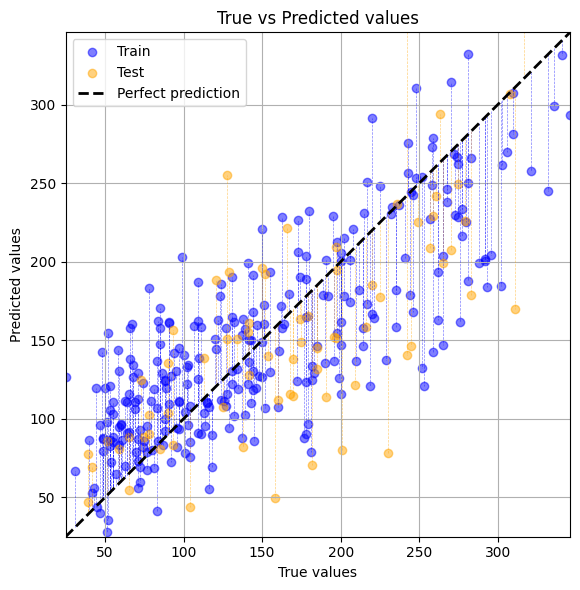

In [22]:
run_experiment(
    linear_model,
    get_pipeline_model_params,
    X_train_val,
    y_train_val,
    X_test_val,
    y_test_val,
)

Train RMSE: 51.74
Test RMSE: 54.01
y_pred = 
      (  149.78)
    + (  -19.08) * X_1
    + (  -11.71) * X_2
    + (   -7.43) * X_3
    + (   -4.72) * X_4
    + (   -9.42) * X_5
    + (    5.28) * X_6
    + (   -1.30) * X_7
    + (    1.95) * X_8
    + (    6.88) * X_9
    + (  -11.94) * X_10
    + (   18.37) * X_11
    + (   19.18) * X_12
    + (   -1.34) * X_13
    + (    4.43) * X_14
    + (   -8.98) * X_15
    + (  -15.48) * X_16
    + (   -4.42) * X_17
    + (    5.23) * X_18
    + (    8.10) * X_19
    + (   -1.48) * X_20
    + (  -11.71) * X_21
    + (   -1.27) * X_22
    + (   11.73) * X_23
    + (   -3.43) * X_24
    + (   -4.61) * X_25
    + (    2.09) * X_26
    + (   -8.97) * X_27
    + (   -3.94) * X_28
    + (    2.31) * X_29
    + (   16.63) * X_30
    + (   19.10) * X_31
    + (   -7.37) * X_32
    + (    5.39) * X_33
    + (   -2.78) * X_34
    + (    2.99) * X_35
    + (    3.25) * X_36
    + (    8.48) * X_37
    + (   -1.74) * X_38
    + (   -1.92) * X_39
    + (    

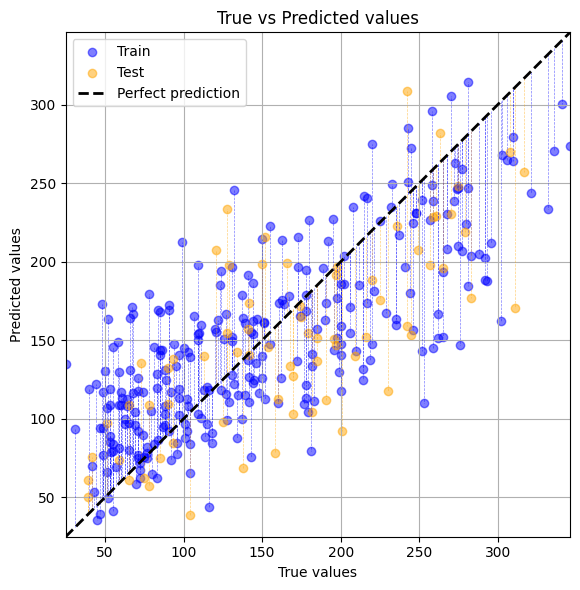

In [23]:
run_experiment(
    ridge_model,
    get_pipeline_model_params,
    X_train_val,
    y_train_val,
    X_test_val,
    y_test_val,
)

Train RMSE: 54.53
Test RMSE: 53.47
y_pred = 
      (  149.78)
    + (    0.00) * X_1
    + (   -0.00) * X_2
    + (    0.00) * X_3
    + (    0.00) * X_4
    + (   -0.00) * X_5
    + (   -0.00) * X_6
    + (   -0.51) * X_7
    + (    0.00) * X_8
    + (    0.00) * X_9
    + (    0.00) * X_10
    + (    0.00) * X_11
    + (    0.00) * X_12
    + (    0.00) * X_13
    + (    0.00) * X_14
    + (    0.00) * X_15
    + (   -0.00) * X_16
    + (   -0.00) * X_17
    + (    0.00) * X_18
    + (    0.00) * X_19
    + (    0.00) * X_20
    + (   -0.00) * X_21
    + (    0.00) * X_22
    + (    0.00) * X_23
    + (   -0.00) * X_24
    + (   -0.00) * X_25
    + (   -7.77) * X_26
    + (    0.00) * X_27
    + (   -0.00) * X_28
    + (   -0.00) * X_29
    + (    0.00) * X_30
    + (   12.83) * X_31
    + (    0.00) * X_32
    + (    0.00) * X_33
    + (   -0.00) * X_34
    + (    0.00) * X_35
    + (   26.52) * X_36
    + (    0.00) * X_37
    + (    0.00) * X_38
    + (    0.00) * X_39
    + (    

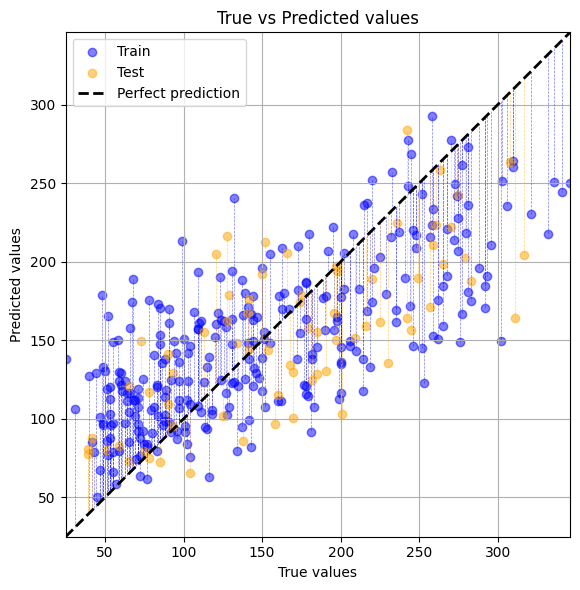

In [24]:
run_experiment(
    lasso_model,
    get_pipeline_model_params,
    X_train_val,
    y_train_val,
    X_test_val,
    y_test_val,
)

### Versão mais "sofisticada": validação cruzada 

In [25]:
from sklearn.model_selection import cross_val_score

cv = 5

simple_model_cv = cross_val_score(
    simple_linear_model,
    X_train,
    y_train,
    cv=cv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
)

linear_model_cv = cross_val_score(
    linear_model,
    X_train,
    y_train,
    cv=cv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
)

ridge_model_cv = cross_val_score(
    ridge_model,
    X_train,
    y_train,
    cv=cv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
)

lasso_model_cv = cross_val_score(
    lasso_model,
    X_train,
    y_train,
    cv=cv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
)

In [26]:
def print_cv_results(model_name, cv_results):
    # Convert negative RMSE to positive RMSE.
    cv_results = -cv_results

    # Print the cross-validation results.
    print(f'{model_name} CV results:')
    print(cv_results)

    # Compute mean and standard deviation of RMSE.
    mean_rmse = cv_results.mean()
    std_rmse = cv_results.std()

    # Print the results.
    print(f'RMSE: {mean_rmse:.2f} +/- {std_rmse:.2f}')
    print()

print_cv_results('Simple Linear Model', simple_model_cv)
print_cv_results('Linear Model', linear_model_cv)
print_cv_results('Ridge Model', ridge_model_cv)
print_cv_results('Lasso Model', lasso_model_cv)

Simple Linear Model CV results:
[52.53034465 58.93522481 52.08727478 56.50041896 59.80716652]
RMSE: 55.97 +/- 3.18

Linear Model CV results:
[58.99985747 70.36744501 62.47355457 66.19624412 59.57251698]
RMSE: 63.52 +/- 4.27

Ridge Model CV results:
[53.89517136 62.47951052 51.46608233 57.24298112 57.5671582 ]
RMSE: 56.53 +/- 3.73

Lasso Model CV results:
[54.57123013 58.76197719 51.97292841 58.42438834 56.3708184 ]
RMSE: 56.02 +/- 2.53



### Escolha de hiperparâmetros com validação cruzada

- Modelo simples não tem nada para escolher, o desempenho é aquele mesmo.

- Os demais modelos tem escolhas a serem feitas no estágio de pré-processamento.

- Os modelos "ridge" e "lasso" tem a escolha do hiperparâmetro `alpha`

- Desempenho do modelo linear simples é obtido simplesmente com `cross_val_score`, como feito acima, não precisa repetir:

In [27]:
print_cv_results('Simple Linear Model', simple_model_cv)

Simple Linear Model CV results:
[52.53034465 58.93522481 52.08727478 56.50041896 59.80716652]
RMSE: 55.97 +/- 3.18



In [29]:
import numpy as np

param_grid_preprocessing = {
    'preprocessing__poly__degree': [1, 2],
    'preprocessing__scaler__with_mean': [True, False],
    'preprocessing__scaler__with_std': [True, False],
}

param_grid_model = {
    'model__alpha': np.logspace(-1, 5, 6),
}

- Calcula o desempenho do modelo linear com pré-processamento

In [30]:
from sklearn.model_selection import GridSearchCV

grid_linear_model = GridSearchCV(
    linear_model,
    param_grid_preprocessing,
    cv=cv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
)
grid_linear_model.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        Pipeline(steps=[('imputer',
                                                         SimpleImputer()),
                                                        ('poly',
                                                         PolynomialFeatures(include_bias=False)),
                                                        ('scaler',
                                                         StandardScaler())])),
                                       ('model', LinearRegression())]),
             n_jobs=-1,
             param_grid={'preprocessing__poly__degree': [1, 2],
                         'preprocessing__scaler__with_mean': [True, False],
                         'preprocessing__scaler__with_std': [True, False]},
             scoring='neg_root_mean_squared_error')

In [31]:
print('Best parameters for linear model:')
print(grid_linear_model.best_params_)

Best parameters for linear model:
{'preprocessing__poly__degree': 1, 'preprocessing__scaler__with_mean': True, 'preprocessing__scaler__with_std': False}


In [32]:
best_linear_model = grid_linear_model.best_estimator_
best_linear_model

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('imputer', SimpleImputer()),
                                 ('poly',
                                  PolynomialFeatures(degree=1,
                                                     include_bias=False)),
                                 ('scaler', StandardScaler(with_std=False))])),
                ('model', LinearRegression())])

In [33]:
print('Best score for ridge model:')
print(grid_linear_model.best_score_.round(2))

Best score for ridge model:
-55.97


In [34]:
pd.DataFrame(grid_linear_model.cv_results_) \
    .sort_values(by='rank_test_score') \
    .iloc[:10, :] \
    .loc[:, ['params', 'mean_test_score', 'std_test_score']] \
    .round(2)


,params,mean_test_score,std_test_score
1,"{'preprocessing__poly__degree': 1, 'preprocess...",-55.97,3.18
0,"{'preprocessing__poly__degree': 1, 'preprocess...",-55.97,3.18
3,"{'preprocessing__poly__degree': 1, 'preprocess...",-55.97,3.18
2,"{'preprocessing__poly__degree': 1, 'preprocess...",-55.97,3.18
7,"{'preprocessing__poly__degree': 2, 'preprocess...",-63.52,4.27
5,"{'preprocessing__poly__degree': 2, 'preprocess...",-63.52,4.27
6,"{'preprocessing__poly__degree': 2, 'preprocess...",-63.52,4.27
4,"{'preprocessing__poly__degree': 2, 'preprocess...",-63.52,4.27


- Calcula o desempenho do modelo Ridge

In [35]:
# Note o truque de Python para concatenar dicionários.
# O operador ** é usado para expandir o dicionário.
# Isso é útil para combinar os parâmetros de pré-processamento e do modelo.
param_grid_ridge = {
    **param_grid_preprocessing,
    **param_grid_model,
}

grid_ridge_model = GridSearchCV(
    ridge_model,
    param_grid_ridge,
    cv=cv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
)
grid_ridge_model.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        Pipeline(steps=[('imputer',
                                                         SimpleImputer()),
                                                        ('poly',
                                                         PolynomialFeatures(include_bias=False)),
                                                        ('scaler',
                                                         StandardScaler())])),
                                       ('model', Ridge(alpha=5.0))]),
             n_jobs=-1,
             param_grid={'model__alpha': array([1.00000000e-01, 1.58489319e+00, 2.51188643e+01, 3.98107171e+02,
       6.30957344e+03, 1.00000000e+05]),
                         'preprocessing__poly__degree': [1, 2],
                         'preprocessing__scaler__with_mean': [True, False],
                         'preprocessing__scaler__with_std': [True, False]},
             scoring='neg_root_mean_squared_error')

In [36]:
print('Best parameters for ridge model:')
print(grid_ridge_model.best_params_)

Best parameters for ridge model:
{'model__alpha': np.float64(25.118864315095795), 'preprocessing__poly__degree': 1, 'preprocessing__scaler__with_mean': True, 'preprocessing__scaler__with_std': True}


In [37]:
print('Best score for ridge model:')
print(grid_ridge_model.best_score_.round(2))

Best score for ridge model:
-55.81


In [38]:
pd.DataFrame(grid_ridge_model.cv_results_) \
    .sort_values(by='rank_test_score') \
    .iloc[:10, :] \
    .loc[:, ['params', 'mean_test_score', 'std_test_score']] \
    .round(2)


,params,mean_test_score,std_test_score
18,"{'model__alpha': 25.118864315095795, 'preproce...",-55.81,2.61
16,"{'model__alpha': 25.118864315095795, 'preproce...",-55.81,2.61
10,"{'model__alpha': 1.5848931924611134, 'preproce...",-55.91,2.91
8,"{'model__alpha': 1.5848931924611134, 'preproce...",-55.91,2.91
2,"{'model__alpha': 0.1, 'preprocessing__poly__de...",-55.96,3.15
0,"{'model__alpha': 0.1, 'preprocessing__poly__de...",-55.96,3.15
11,"{'model__alpha': 1.5848931924611134, 'preproce...",-55.97,2.95
9,"{'model__alpha': 1.5848931924611134, 'preproce...",-55.97,2.95
3,"{'model__alpha': 0.1, 'preprocessing__poly__de...",-55.97,3.17
1,"{'model__alpha': 0.1, 'preprocessing__poly__de...",-55.97,3.17


- Calcula o desempenho do modelo Lasso

In [39]:
# Note o truque de Python para concatenar dicionários.
# O operador ** é usado para expandir o dicionário.
# Isso é útil para combinar os parâmetros de pré-processamento e do modelo.
param_grid_lasso = {
    **param_grid_preprocessing,
    **param_grid_model,
}

grid_lasso_model = GridSearchCV(
    lasso_model,
    param_grid_lasso,
    cv=cv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
)
grid_lasso_model.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        Pipeline(steps=[('imputer',
                                                         SimpleImputer()),
                                                        ('poly',
                                                         PolynomialFeatures(include_bias=False)),
                                                        ('scaler',
                                                         StandardScaler())])),
                                       ('model', Lasso(alpha=5.0))]),
             n_jobs=-1,
             param_grid={'model__alpha': array([1.00000000e-01, 1.58489319e+00, 2.51188643e+01, 3.98107171e+02,
       6.30957344e+03, 1.00000000e+05]),
                         'preprocessing__poly__degree': [1, 2],
                         'preprocessing__scaler__with_mean': [True, False],
                         'preprocessing__scaler__with_std': [True, False]},
             scoring='neg_root_mean_squared_error')

In [40]:
print('Best parameters for lasso model:')
print(grid_lasso_model.best_params_)

Best parameters for lasso model:
{'model__alpha': np.float64(1.5848931924611134), 'preprocessing__poly__degree': 2, 'preprocessing__scaler__with_mean': True, 'preprocessing__scaler__with_std': True}


In [41]:
print('Best score for lasso model:')
print(grid_lasso_model.best_score_.round(2))

Best score for lasso model:
-55.79


In [42]:
pd.DataFrame(grid_lasso_model.cv_results_) \
    .sort_values(by='rank_test_score') \
    .iloc[:10, :] \
    .loc[:, ['params', 'mean_test_score', 'std_test_score']] \
    .round(2)


,params,mean_test_score,std_test_score
12,"{'model__alpha': 1.5848931924611134, 'preproce...",-55.79,2.44
14,"{'model__alpha': 1.5848931924611134, 'preproce...",-55.79,2.44
10,"{'model__alpha': 1.5848931924611134, 'preproce...",-55.86,2.40
8,"{'model__alpha': 1.5848931924611134, 'preproce...",-55.86,2.40
2,"{'model__alpha': 0.1, 'preprocessing__poly__de...",-55.92,2.95
0,"{'model__alpha': 0.1, 'preprocessing__poly__de...",-55.92,2.95
1,"{'model__alpha': 0.1, 'preprocessing__poly__de...",-55.98,3.08
3,"{'model__alpha': 0.1, 'preprocessing__poly__de...",-55.98,3.08
11,"{'model__alpha': 1.5848931924611134, 'preproce...",-56.69,2.07
9,"{'model__alpha': 1.5848931924611134, 'preproce...",-56.69,2.07


- Sumário dos melhores escores:

In [43]:
print(f'Simple linear model: {simple_model_cv.mean().round(2)}')
print(f'Linear model: {grid_linear_model.best_score_.round(2)}')
print(f'Ridge: {grid_ridge_model.best_score_.round(2)}')
print(f'Lasso: {grid_lasso_model.best_score_.round(2)}')

Simple linear model: -55.97
Linear model: -55.97
Ridge: -55.81
Lasso: -55.79


## Atividades

- Verifique os coeficientes do melhor modelo LASSO para ver quais *features* são mais relevantes.

- Treine um modelo linear sem regularização com apenas as features escolhidas pelo LASSO, compare com o modelo linear completo


In [47]:
# Verifique os coeficientes do melhor modelo LASSO para ver quais features são mais relevantes.
grid_lasso_model.best_score_.round(2)
best_lasso_model = grid_lasso_model.best_estimator_
intercept, coefs = get_pipeline_model_params(best_lasso_model)

In [ ]:
intercept, coefs
# Convert the coefficients to a DataFrame for better readability.
# Retrieve the polynomial features transformer from the best LASSO model.
poly = best_lasso_model.named_steps['preprocessing'].named_steps['poly']

# Get the expanded feature names based on the original columns.
feature_names = poly.get_feature_names_out(X_train.columns)

coef_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefs,
}).sort_values(by='coefficient', ascending=False)
coef_df.reset_index(drop=True, inplace=True)
coef_df

,feature,coefficient
0,bmi bp,27.340712
1,s5,12.080921
2,bmi s5,9.611755
3,s5 s6,2.942216
4,bmi s4,1.862323
...,...,...
60,s3 s6,-0.000000
61,s6^2,0.000000
62,s3,-0.660480
63,s2 s3,-6.628771


Train RMSE: 53.47
Test RMSE: 54.22
y_pred = 
      (  153.74)
    + (   28.63) * X_1
    + (   38.73) * X_2
    + (  -49.09) * X_3
    + (    0.68) * X_4
    + (   10.30) * X_5
    + (    8.20) * X_6
    + (    5.62) * X_7
    + (   34.39) * X_8
    + (   -6.34) * X_9
    + (    1.08) * X_10
    + (   -9.38) * X_11
    + (  -10.79) * X_12



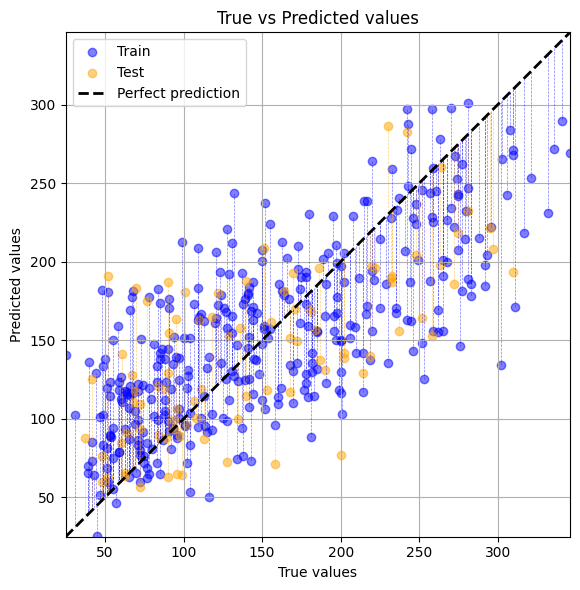

Train RMSE: 48.28
Test RMSE: 59.41
y_pred = 
      (  149.78)
    + ( -142.07) * X_1
    + (   15.60) * X_2
    + ( -200.41) * X_3
    + (  211.97) * X_4
    + (  878.86) * X_5
    + ( -776.75) * X_6
    + ( -134.37) * X_7
    + (  192.05) * X_8
    + ( -170.12) * X_9
    + ( -195.98) * X_10
    + (   43.70) * X_11
    + (   23.39) * X_12
    + (   -8.80) * X_13
    + (   15.49) * X_14
    + (  -83.74) * X_15
    + (  -56.73) * X_16
    + (   82.69) * X_17
    + (   97.49) * X_18
    + (   67.80) * X_19
    + (    6.95) * X_20
    + (   15.60) * X_21
    + (   10.27) * X_22
    + (   34.56) * X_23
    + (  182.81) * X_24
    + (  -66.78) * X_25
    + (  -74.76) * X_26
    + ( -118.63) * X_27
    + (  -76.86) * X_28
    + (    8.65) * X_29
    + (   53.50) * X_30
    + (   88.10) * X_31
    + ( -315.38) * X_32
    + (  281.72) * X_33
    + (   63.81) * X_34
    + (  -63.25) * X_35
    + (  207.10) * X_36
    + (   10.31) * X_37
    + (   -4.41) * X_38
    + (  639.44) * X_39
    + ( -43

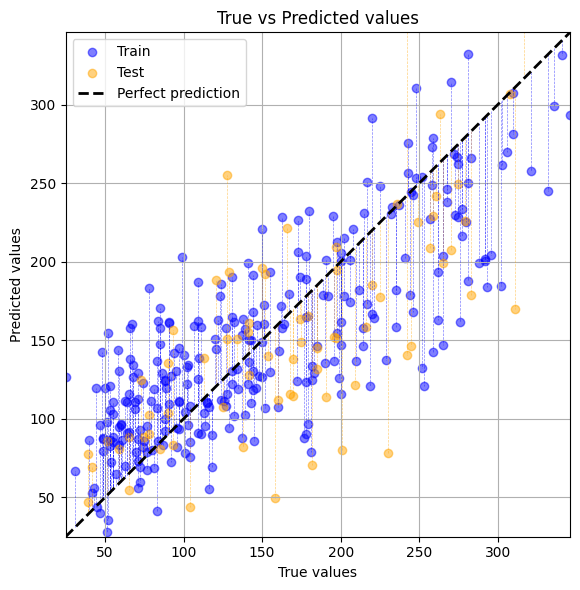

In [ ]:
# Treine um modelo linear sem regularização com apenas as features escolhidas pelo LASSO, compare com o modelo linear completo

# Use the preprocessing pipeline from the best LASSO model to transform the data first.
preprocessing = best_lasso_model.named_steps['preprocessing']
X_train_transformed = preprocessing.transform(X_train)
X_test_transformed = preprocessing.transform(X_test)

# Get the feature names from the polynomial transformation.
feature_names_transformed = best_lasso_model.named_steps['preprocessing'].named_steps['poly'].get_feature_names_out(X_train.columns)

# Create DataFrames with the transformed features.
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=feature_names_transformed, index=X_train.index)
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=feature_names_transformed, index=X_test.index)

selected_features = coef_df[coef_df['coefficient'] != 0]['feature'].tolist()
selected_X_train = X_train_transformed_df[selected_features]
selected_X_test = X_test_transformed_df[selected_features]

selected_linear_model = create_simple_linear_model()

run_experiment(
    selected_linear_model,
    get_simple_model_params,
    selected_X_train,
    y_train,
    selected_X_test,
    y_test,
)

run_experiment(
    linear_model,
    get_pipeline_model_params,
    X_train_val,
    y_train_val,
    X_test_val,
    y_test_val,
)

# Aqui a gente percebe como o modelo linear utilizando apenas as variáveis selecionadas pelo LASSO tem um desempenho muito mais confiável
# que o modelo linear normal, que overfitou claramente os dados de trieno